<a href="https://colab.research.google.com/github/Antu0/Resistivity-Data-Correction/blob/main/Resistivity_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import pandas as pd
import numpy as np
from scipy.interpolate import griddata
from scipy import ndimage
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor

In [37]:
!pip install torch_geometric

In [38]:
excel_file_path = "/content/drive/MyDrive/Antu /Projects/Resistivity/ML_data/Data.xlsx"
df = pd.read_excel(excel_file_path)
display(df.head(10))

,C2,C1,P1,P2,X_plot,Spacing,n_factor,A_resistivity
0,0,7,14,21,10.5,7.0,1.0,2.65715
1,0,7,21,28,14.0,7.0,2.0,3.26739
2,0,7,28,35,17.5,7.0,3.0,3.53439
3,0,7,35,42,21.0,7.0,4.0,3.76092
4,0,7,42,49,24.5,7.0,5.0,4.26496
5,0,7,49,56,28.0,7.0,6.0,5.94763
6,0,7,56,63,31.5,7.0,7.0,5.27678
7,0,7,63,70,35.0,7.0,8.0,5.17314
8,7,14,21,28,17.5,7.0,1.0,2.53883
9,7,14,28,35,21.0,7.0,2.0,2.97291


In [39]:
display(df.describe())

,C2,C1,P1,P2,X_plot,Spacing,n_factor,A_resistivity
count,3217.000000,3217.000000,3217.000000,3217.000000,2967.000000,2967.000000,2967.000000,2967.000000
mean,213.599005,238.563569,338.345664,363.310227,288.533536,25.213684,4.064038,11.633161
std,136.927600,134.020364,135.028758,138.298746,129.270748,13.833156,2.250783,48.194479
min,0.000000,7.000000,14.000000,21.000000,10.500000,7.000000,1.000000,0.001020
25%,98.000000,126.000000,231.000000,259.000000,185.500000,14.000000,2.000000,3.038170
50%,203.000000,231.000000,350.000000,378.000000,287.000000,21.000000,4.000000,4.868610
75%,322.000000,343.000000,455.000000,483.000000,392.000000,35.000000,6.000000,7.852960
max,560.000000,567.000000,574.000000,581.000000,570.500000,49.000000,8.000000,1315.620000


In [40]:
df['Z_plot'] = (abs(df['P2'] - df['C2'])) * 0.15
display(df.head())

,C2,C1,P1,P2,X_plot,Spacing,n_factor,A_resistivity,Z_plot
0,0,7,14,21,10.5,7.0,1.0,2.65715,3.15
1,0,7,21,28,14.0,7.0,2.0,3.26739,4.20
2,0,7,28,35,17.5,7.0,3.0,3.53439,5.25
3,0,7,35,42,21.0,7.0,4.0,3.76092,6.30
4,0,7,42,49,24.5,7.0,5.0,4.26496,7.35


In [41]:
import numpy as np
from scipy.interpolate import griddata

def grid_data(df, resolution=(600, 100)): # Updated resolution
  """
  Grids the resistivity data onto a regular grid.

  Args:
    df: Pandas DataFrame containing 'X_plot', 'Z_plot', and 'A_resistivity' columns.
    resolution: A tuple specifying the number of points in the x and z directions.

  Returns:
    A tuple containing:
      - gridded_resistivity: 2D NumPy array of interpolated resistivity values.
      - xi: 1D NumPy array of x-coordinates for the grid.
      - zi: 1D NumPy array of z-coordinates for the grid.
  """
  # Drop rows with missing values in the relevant columns
  df_cleaned = df.dropna(subset=['X_plot', 'Z_plot', 'A_resistivity']).copy()

  # Define grid dimensions
  x_min, x_max = df_cleaned['X_plot'].min(), df_cleaned['X_plot'].max()
  z_min, z_max = df_cleaned['Z_plot'].min(), df_cleaned['Z_plot'].max()

  xi = np.linspace(x_min, x_max, resolution[0])
  zi = np.linspace(z_min, z_max, resolution[1]) # Invert z-axis for plotting convention
  xi, zi = np.meshgrid(xi, zi)

  # Get the coordinates and values for interpolation
  points = df_cleaned[['X_plot', 'Z_plot']].values
  values = df_cleaned['A_resistivity'].values

  # Interpolate the data
  gridded_resistivity = griddata(points, values, (xi, zi), method='cubic') # Using 'cubic' as it was used before and provides smooth results

  return gridded_resistivity, xi, zi

In [42]:
# Call the modified grid_data function
gridded_resistivity, xi, zi = grid_data(df)

# Display the shape of the resulting gridded data
print("Shape of gridded resistivity data:", gridded_resistivity.shape)

Shape of gridded resistivity data: (100, 600)


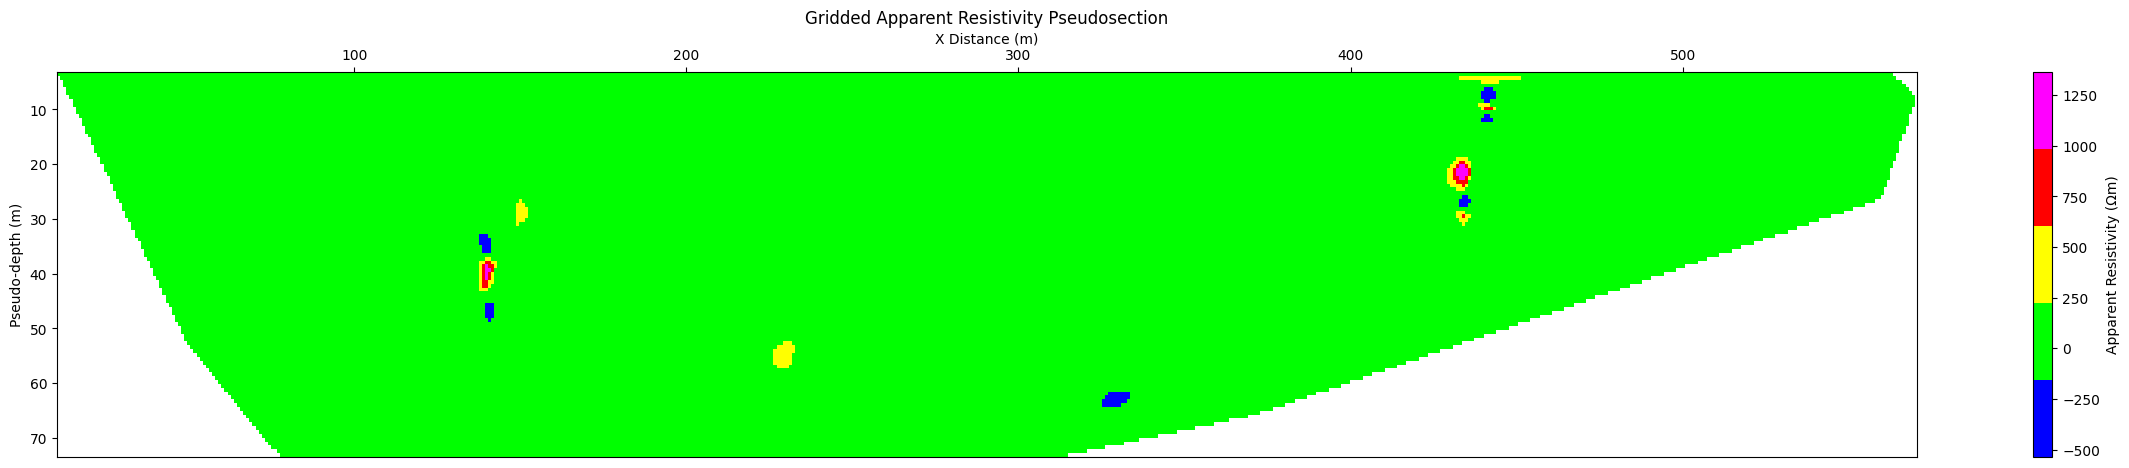

In [43]:
import matplotlib.colors as mcolors # Import the mcolors module

# Create the plot
fig, ax = plt.subplots(figsize=(30, 5))

# Choose a colormap
colors = ['#0000ff', '#00ff00', '#ffff00', '#ff0000', '#ff00ff'] # Blue, Green, Yellow, Red, Purple
cmap = mcolors.ListedColormap(colors)

# Plot the gridded data using imshow with corrected parameters
im = ax.imshow(gridded_resistivity,
               extent=[xi.min(), xi.max(), zi.max(), zi.min()],
               origin='upper',
               aspect='auto',
               cmap=cmap)

# Add a colorbar
cbar = fig.colorbar(im, ax=ax, label='Apparent Resistivity (Ωm)')

# Set labels and title
ax.set_xlabel('X Distance (m)')
ax.set_ylabel('Pseudo-depth (m)')
ax.set_title('Gridded Apparent Resistivity Pseudosection')

# The y-axis is now correctly oriented, so we DO NOT need ax.invert_yaxis()

ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')


plt.show()

In [44]:
from sklearn.neighbors import LocalOutlierFactor
import numpy as np

def calculate_lof_feature(gridded_resistivity, n_neighbors=20):
  """
  Calculates the Local Outlier Factor (LOF) for gridded resistivity data.

  Args:
    gridded_resistivity: 2D NumPy array of gridded resistivity values.
    n_neighbors: The number of neighbors to consider for the LOF calculation.

  Returns:
    A 2D NumPy array of LOF scores, reshaped to the original grid shape.
  """
  # Store the original shape
  original_shape = gridded_resistivity.shape

  # Reshape the 2D grid into a 1D array
  # Filter out NaN values before applying LOF
  flattened_data = gridded_resistivity[~np.isnan(gridded_resistivity)].reshape(-1, 1)


  # Initialize LocalOutlierFactor
  lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination='auto')

  # Apply the LOF model to the data
  # Fit_predict returns -1 for outliers, 1 for inliers
  # We need the negative_outlier_factor_ which represents the local reachability density ratio
  lof.fit(flattened_data)

  # Retrieve the negative_outlier_factor_ and multiply by -1
  # Higher values now indicate higher anomaly score
  lof_scores_flat = -lof.negative_outlier_factor_

  # Create a new array with the original shape and fill with NaNs
  lof_feature_grid = np.full(original_shape, np.nan)

  # Fill the new array with LOF scores, putting NaNs back in their original positions
  lof_feature_grid[~np.isnan(gridded_resistivity)] = lof_scores_flat


  return lof_feature_grid

In [45]:
from scipy import ndimage
import numpy as np

def calculate_statistical_features(gridded_resistivity, window_size=5):
  """
  Calculates neighborhood statistical features for a 2D array using a moving window.

  Args:
    gridded_resistivity: 2D NumPy array.
    window_size: The size of the moving window (e.g., 5 for a 5x5 window).

  Returns:
    A tuple containing:
      - mean_feature: 2D NumPy array of neighborhood means.
      - median_feature: 2D NumPy array of neighborhood medians.
      - std_feature: 2D NumPy array of neighborhood standard deviations.
      - var_feature: 2D NumPy array of neighborhood variances.
  """
  # Define the footprint for the moving window
  footprint = np.ones((window_size, window_size))

  # Define functions for the statistical measures
  def mean_filter(values):
    return np.mean(values)

  def median_filter(values):
    return np.median(values)

  def std_filter(values):
    return np.std(values)

  def var_filter(values):
    return np.var(values)


  # Compute the statistical features using generic_filter
  mean_feature = ndimage.generic_filter(gridded_resistivity, mean_filter, footprint=footprint)
  median_feature = ndimage.generic_filter(gridded_resistivity, median_filter, footprint=footprint)
  std_feature = ndimage.generic_filter(gridded_resistivity, std_filter, footprint=footprint)
  var_feature = ndimage.generic_filter(gridded_resistivity, var_filter, footprint=footprint)

  return mean_feature, median_feature, std_feature, var_feature

In [46]:
from scipy import ndimage
import numpy as np

def calculate_gradient_features(gridded_resistivity):
  """
  Calculates gradient features for a 2D array using Sobel kernels.

  Args:
    gridded_resistivity: 2D NumPy array.

  Returns:
    A tuple containing:
      - gradient_x: 2D NumPy array of horizontal gradients.
      - gradient_z: 2D NumPy array of vertical gradients.
      - gradient_magnitude: 2D NumPy array of gradient magnitudes.
  """
  # Define Sobel kernels
  kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
  kz = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

  # Apply kernels using convolution
  gradient_x = ndimage.convolve(gridded_resistivity, kx)
  gradient_z = ndimage.convolve(gridded_resistivity, kz)

  # Calculate gradient magnitude
  gradient_magnitude = np.sqrt(gradient_x**2 + gradient_z**2)

  return gradient_x, gradient_z, gradient_magnitude

In [47]:
from sklearn.preprocessing import StandardScaler
import numpy as np

def assemble_and_standardize_features(gridded_resistivity, lof_feature, mean_feature, median_feature, std_feature, var_feature, gradient_x, gradient_z, gradient_magnitude):
  """
  Assembles and standardizes the 2D feature grids into a single standardized feature matrix.

  Args:
    gridded_resistivity: 2D NumPy array of gridded resistivity values.
    lof_feature: 2D NumPy array of LOF scores.
    mean_feature: 2D NumPy array of neighborhood means.
    median_feature: 2D NumPy array of neighborhood medians.
    std_feature: 2D NumPy array of neighborhood standard deviations.
    var_feature: 2D NumPy array of neighborhood variances.
    gradient_x: 2D NumPy array of horizontal gradients.
    gradient_z: 2D NumPy array of vertical gradients.
    gradient_magnitude: 2D NumPy array of gradient magnitudes.

  Returns:
    A 2D NumPy array representing the standardized feature matrix of shape (num_nodes, num_features).
  """
  # Stack all the 2D feature grids into a single 3D NumPy array
  feature_stack = np.stack([gridded_resistivity, lof_feature, mean_feature, median_feature, std_feature, var_feature, gradient_x, gradient_z, gradient_magnitude], axis=-1)

  # Get the shape of the 3D array
  height, width, num_features = feature_stack.shape

  # Reshape the 3D array into a 2D feature matrix
  feature_matrix = feature_stack.reshape(height * width, num_features)

  # Let's find the mean of each feature column, ignoring NaNs
  col_means = np.nanmean(feature_matrix, axis=0)

  # Find the indices where there are NaNs
  nan_indices = np.isnan(feature_matrix)

  # Replace NaNs with the column mean
  # Use broadcasting to replace NaNs in each column with the corresponding column mean
  feature_matrix[nan_indices] = np.take(col_means, np.where(nan_indices)[1])

  # Initialize StandardScaler
  scaler = StandardScaler()

  # Scale the feature matrix
  standardized_feature_matrix = scaler.fit_transform(feature_matrix)

  return standardized_feature_matrix

In [48]:
# Call grid_data to get xi and zi
gridded_resistivity, xi, zi = grid_data(df)

# Call calculate_gradient_features to get gradient_magnitude
gradient_x, gradient_z, gradient_magnitude = calculate_gradient_features(gridded_resistivity)

# Now you can run the plotting code for gradient_magnitude

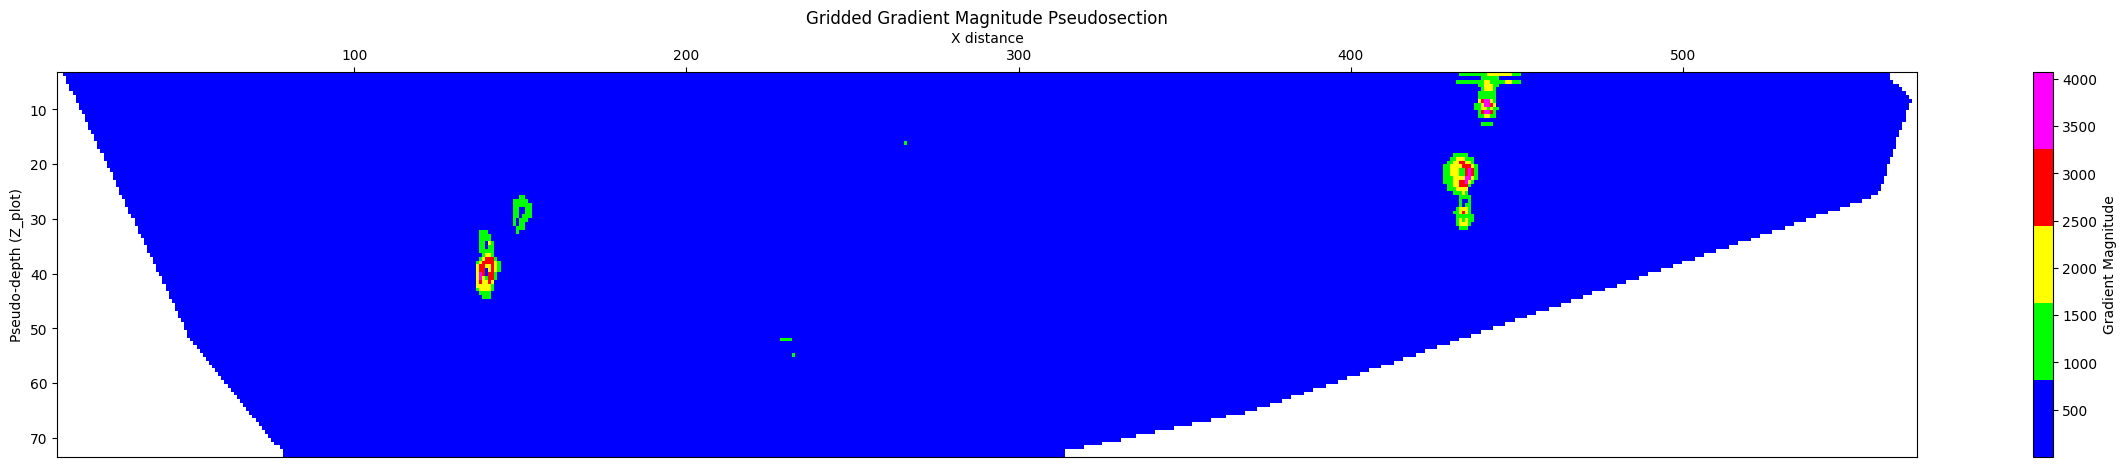

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming gradient_magnitude, xi, and zi are available from previous steps

# Create the plot for Gradient Magnitude
fig, ax = plt.subplots(figsize=(30, 5))

# Choose a colormap
colors = ['#0000ff', '#00ff00', '#ffff00', '#ff0000', '#ff00ff'] # Blue, Green, Yellow, Red, Purple
cmap = mcolors.ListedColormap(colors)

# Plot the gridded data using imshow
im = ax.imshow(gradient_magnitude, extent=[xi.min(), xi.max(), zi.max(), zi.min()],
               origin='upper', aspect='auto', cmap=cmap)

# Add a colorbar
cbar = fig.colorbar(im, ax=ax, label='Gradient Magnitude')

# Set labels and title
ax.set_xlabel('X distance')
ax.set_ylabel('Pseudo-depth (Z_plot)')
ax.set_title('Gridded Gradient Magnitude Pseudosection')



# Optional: Improve tick locations for better readability
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')


plt.show()

In [50]:
# Call calculate_lof_feature to get lof_feature
lof_feature = calculate_lof_feature(gridded_resistivity)

# Now you can run the plotting code for lof_feature

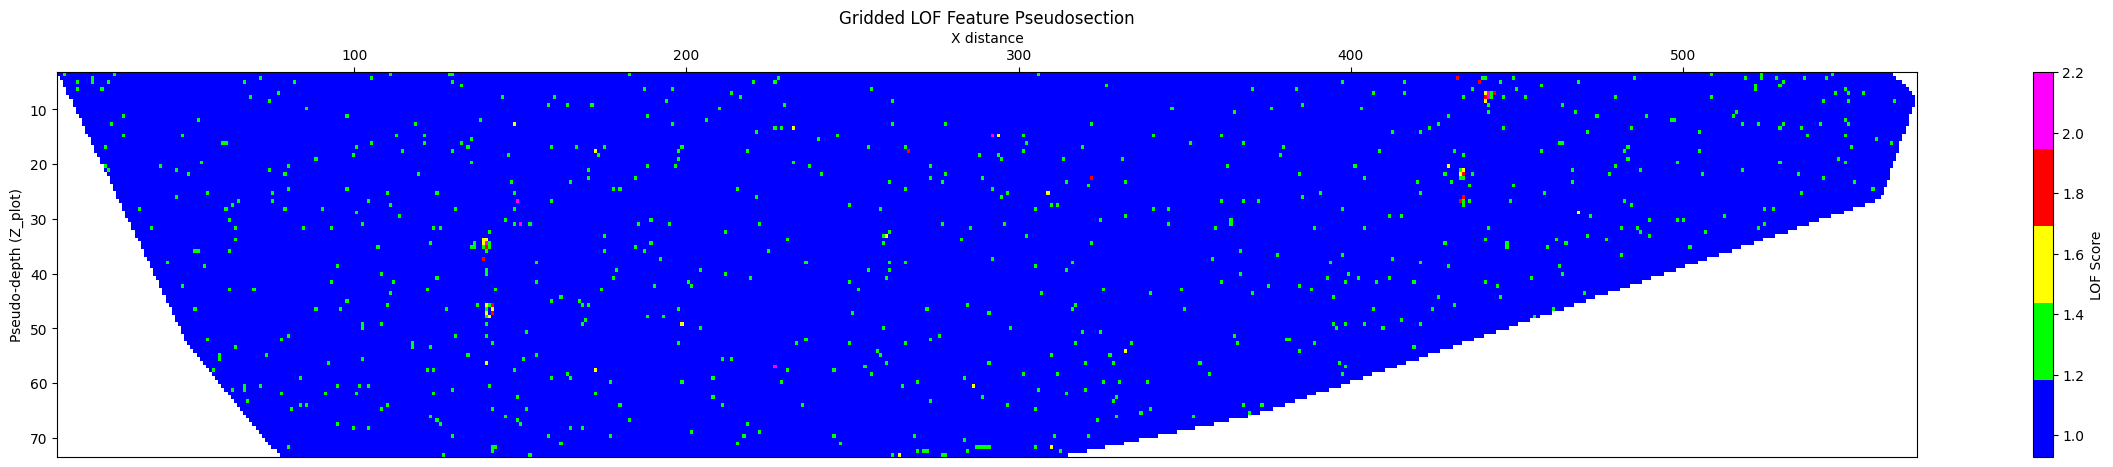

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming lof_feature, xi, and zi are available from previous steps

# Create the plot for LOF Feature
fig, ax = plt.subplots(figsize=(30, 5))

colors = ['#0000ff', '#00ff00', '#ffff00', '#ff0000', '#ff00ff'] # Blue, Green, Yellow, Red, Purple
cmap = mcolors.ListedColormap(colors)

# Plot the gridded data using imshow
im = ax.imshow(lof_feature, extent=[xi.min(), xi.max(), zi.max(), zi.min()],
               origin='upper', aspect='auto', cmap=cmap)

# Add a colorbar
cbar = fig.colorbar(im, ax=ax, label='LOF Score')

# Set labels and title
ax.set_xlabel('X distance')
ax.set_ylabel('Pseudo-depth (Z_plot)')
ax.set_title('Gridded LOF Feature Pseudosection')



# Improve tick locations for better readability
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

plt.show()

In [52]:
import torch
from torch_geometric.data import Data

def build_graph(standardized_feature_matrix, height, width):
    """
    Builds a graph representation of the gridded data.

    Args:
        standardized_feature_matrix: 2D NumPy array of standardized features
                                     with shape (num_nodes, num_features).
        height: The height of the original grid.
        width: The width of the original grid.

    Returns:
        A torch_geometric.data.Data object representing the graph.
    """
    # Convert the NumPy feature matrix into a tensor
    node_features = torch.tensor(standardized_feature_matrix, dtype=torch.float)

    # Create the graph's edge list (8-way connectivity)
    edge_list = []
    for i in range(height):
        for j in range(width):
            # Get the index of the current node
            current_node_index = i * width + j

            # Define the relative positions of the 8 neighbors
            neighbors = [
                (-1, -1), (-1, 0), (-1, 1),
                (0, -1),           (0, 1),
                (1, -1),  (1, 0),  (1, 1)
            ]

            # Iterate through neighbors and add edges
            for di, dj in neighbors:
                ni, nj = i + di, j + dj

                # Check if the neighbor is within the grid bounds
                if 0 <= ni < height and 0 <= nj < width:
                    neighbor_node_index = ni * width + nj
                    edge_list.append([current_node_index, neighbor_node_index])

    # Convert the edge list into a PyTorch tensor
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()

    # Create an instance of torch_geometric.data.Data
    data = Data(x=node_features, edge_index=edge_index)

    return data

In [53]:
# Call calculate_statistical_features to get the statistical features
mean_feature, median_feature, std_feature, var_feature = calculate_statistical_features(gridded_resistivity)

In [54]:
# Calculate the height and width from one of the gridded feature arrays
height, width = gridded_resistivity.shape

# Assemble and standardize the features
standardized_feature_matrix = assemble_and_standardize_features(
    gridded_resistivity,
    lof_feature,
    mean_feature,
    median_feature,
    std_feature,
    var_feature,
    gradient_x,
    gradient_z,
    gradient_magnitude
)

# Build the graph
graph_data = build_graph(standardized_feature_matrix, height, width)

# Print the graph data object to inspect its structure
print(graph_data)

Data(x=[60000, 9], edge_index=[2, 475804])


In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GraphAutoencoder(nn.Module):
    def __init__(self, in_channels, latent_dim, intermediate_dim):
        """
        Initializes the GraphAutoencoder model.

        Args:
            in_channels: The number of input features per node.
            latent_dim: The dimension of the latent space.
            intermediate_dim: The dimension of the intermediate layer in the encoder and decoder.
        """
        super(GraphAutoencoder, self).__init__()

        # Encoder layers
        self.encoder1 = GCNConv(in_channels, intermediate_dim)
        self.encoder2 = GCNConv(intermediate_dim, latent_dim)

        # Decoder layers
        self.decoder1 = GCNConv(latent_dim, intermediate_dim)
        self.decoder2 = GCNConv(intermediate_dim, in_channels)

    def encode(self, x, edge_index):
        """
        Encodes the input features into the latent space.

        Args:
            x: Node feature tensor.
            edge_index: Edge index tensor.

        Returns:
            The latent space embeddings.
        """
        x = self.encoder1(x, edge_index)
        x = F.relu(x)
        x = self.encoder2(x, edge_index)
        return x

    def decode(self, z, edge_index):
        """
        Decodes the latent embeddings back to the original feature space.

        Args:
            z: Latent space embeddings.
            edge_index: Edge index tensor.

        Returns:
            The reconstructed feature matrix.
        """
        z = self.decoder1(z, edge_index)
        z = F.relu(z)
        z = self.decoder2(z, edge_index)
        return z

    def forward(self, x, edge_index):
        """
        Forward pass of the GraphAutoencoder.

        Args:
            x: Node feature tensor.
            edge_index: Edge index tensor.

        Returns:
            The reconstructed feature matrix.
        """
        latent_embeddings = self.encode(x, edge_index)
        reconstructed_features = self.decode(latent_embeddings, edge_index)
        return reconstructed_features

In [56]:
import torch
import torch.nn.functional as F
import torch.optim as optim

def train_gae(model, data, epochs, learning_rate):
    """
    Trains the GraphAutoencoder model.

    Args:
        model: The GraphAutoencoder model instance.
        data: The torch_geometric.data.Data object representing the graph.
        epochs: The number of training epochs.
        learning_rate: The learning rate for the optimizer.

    Returns:
        The trained GraphAutoencoder model.
    """
    # Instantiate an Adam optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Define the loss function as Mean Squared Error
    criterion = F.mse_loss

    # Training loop
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        optimizer.zero_grad()  # Clear the gradients

        # Forward pass
        reconstructed_features = model(data.x, data.edge_index)

        # Calculate the loss
        loss = criterion(reconstructed_features, data.x)

        # Backpropagation
        loss.backward()

        # Update weights
        optimizer.step()

        # Print the loss periodically
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    return model

In [57]:
import torch
import numpy as np

def calculate_anomaly_scores(model, data, percentile=98):
    """
    Calculates anomaly scores based on the reconstruction error of the GAE.

    Args:
        model: The trained GraphAutoencoder model.
        data: The torch_geometric.data.Data object representing the graph.
        percentile: The percentile to use for the anomaly threshold (e.g., 98 for 98th percentile).

    Returns:
        A tuple containing:
            - anomaly_scores: A 1D tensor of anomaly scores (reconstruction errors) for each node.
            - anomaly_mask: A boolean tensor that is True for nodes exceeding the anomaly threshold.
    """
    # Set the model to evaluation mode
    model.eval()

    # Ensure gradients are not calculated during evaluation
    with torch.no_grad():
        # Perform a forward pass to get the reconstructed feature matrix
        reconstructed_features = model(data.x, data.edge_index)

        # Calculate the node-wise reconstruction error (MSE across the feature dimension)
        # The result will be a 1D tensor with one error value per node
        anomaly_scores = F.mse_loss(reconstructed_features, data.x, reduction='none').mean(dim=1)


    # Calculate the anomaly threshold (e.g., 98th percentile)
    # Convert to numpy array for percentile calculation
    anomaly_scores_np = anomaly_scores.numpy()
    anomaly_threshold = np.percentile(anomaly_scores_np, percentile)

    # Create a boolean mask for anomalies
    anomaly_mask = anomaly_scores > anomaly_threshold

    return anomaly_scores, anomaly_mask

In [58]:
import numpy as np

def impute_anomalies(gridded_resistivity, anomaly_mask, reconstructed_features, height, width):
    """
    Imputes anomalous values in the gridded resistivity data using reconstructed values from the GAE.

    Args:
        gridded_resistivity: Original 2D NumPy array of gridded resistivity values.
        anomaly_mask: Boolean tensor or NumPy array of the same shape as the flattened grid,
                      True for anomalous nodes.
        reconstructed_features: 2D NumPy array of reconstructed features from the GAE
                                with shape (num_nodes, num_features).
        height: The height of the original grid.
        width: The width of the original grid.

    Returns:
        A 2D NumPy array representing the cleaned and imputed resistivity grid.
    """
    # Create a copy of the original gridded resistivity data
    imputed_resistivity = np.copy(gridded_resistivity)

    # The first feature in the reconstructed matrix is the reconstructed resistivity
    reconstructed_resistivity_flat = reconstructed_features[:, 0]

    # Reshape both the boolean mask and the reconstructed resistivity array back to 2D grid shape
    anomaly_mask_2d = anomaly_mask.reshape(height, width)
    reconstructed_resistivity_2d = reconstructed_resistivity_flat.reshape(height, width)

    # Use the 2D boolean mask to identify and replace anomalous values
    imputed_resistivity[anomaly_mask_2d] = reconstructed_resistivity_2d[anomaly_mask_2d]

    return imputed_resistivity

In [67]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors # Import mcolors for colormap consistency

def visualize_results(original_gridded_resistivity, anomaly_scores_2d, cleaned_gridded_resistivity, xi, zi):
    """
    Visualizes the original, anomaly score, and cleaned resistivity grids.

    Args:
        original_gridded_resistivity: 2D NumPy array of original gridded resistivity values.
        anomaly_scores_2d: 2D NumPy array of anomaly scores reshaped to grid shape.
        cleaned_gridded_resistivity: 2D NumPy array of cleaned and imputed resistivity values.
        xi: 2D NumPy array of x-coordinates for the grid.
        zi: 2D NumPy array of z-coordinates for the grid.
    """
    fig, axes = plt.subplots(3, 1, figsize=(30, 18))

    # Set a fixed color scale for resistivity plots from 0 to 200.
    vmax = 200
    vmin = 0

    # Plot 1: Original Pseudo-section
    im1 = axes[0].imshow(original_gridded_resistivity,
                         extent=[xi.min(), xi.max(), zi.max(), zi.min()],
                         origin='upper',
                         aspect='auto',
                         cmap='turbo', # Changed colormap to turbo
                         vmin=vmin, vmax=vmax)
    fig.colorbar(im1, ax=axes[0], label='Apparent Resistivity (Ωm)')
    axes[0].set_xlabel('X Distance (m)')
    axes[0].set_ylabel('Pseudo-depth (m)')
    axes[0].set_title('Original Gridded Data')
    axes[0].xaxis.set_ticks_position('top')
    axes[0].xaxis.set_label_position('top')


    # Plot 2: Anomaly Score Heatmap
    im2 = axes[1].imshow(anomaly_scores_2d,
                         extent=[xi.min(), xi.max(), zi.max(), zi.min()],
                         origin='upper',
                         aspect='auto',
                         cmap='OrRd') # Changed colormap to OrRd
    fig.colorbar(im2, ax=axes[1], label='Anomaly Score')
    axes[1].set_xlabel('X Distance (m)')
    axes[1].set_ylabel('Pseudo-depth (m)')
    axes[1].set_title('Node Anomaly Scores')
    axes[1].xaxis.set_ticks_position('top')
    axes[1].xaxis.set_label_position('top')


    # Plot 3: Cleaned Pseudo-section
    im3 = axes[2].imshow(cleaned_gridded_resistivity,
                         extent=[xi.min(), xi.max(), zi.max(), zi.min()],
                         origin='upper',
                         aspect='auto',
                         cmap='turbo', # Use the same colormap as the original for comparison
                         vmin=vmin, vmax=vmax) # Use the same color scale as the original
    fig.colorbar(im3, ax=axes[2], label='Apparent Resistivity (Ωm)')
    axes[2].set_xlabel('X Distance (m)')
    axes[2].set_ylabel('Pseudo-depth (m)')
    axes[2].set_title('Cleaned and Imputed Data')
    axes[2].xaxis.set_ticks_position('top')
    axes[2].xaxis.set_label_position('top')


    plt.tight_layout()
    plt.show()



Graph built successfully.
Data(x=[60000, 9], edge_index=[2, 475804])
GraphAutoencoder model instantiated.
Training GAE for 200 epochs with learning rate 0.001...
Epoch [10/200], Loss: 0.8474
Epoch [20/200], Loss: 0.6802
Epoch [30/200], Loss: 0.5888
Epoch [40/200], Loss: 0.5281
Epoch [50/200], Loss: 0.4738
Epoch [60/200], Loss: 0.4267
Epoch [70/200], Loss: 0.3885
Epoch [80/200], Loss: 0.3564
Epoch [90/200], Loss: 0.3281
Epoch [100/200], Loss: 0.3030
Epoch [110/200], Loss: 0.2825
Epoch [120/200], Loss: 0.2664
Epoch [130/200], Loss: 0.2535
Epoch [140/200], Loss: 0.2427
Epoch [150/200], Loss: 0.2336
Epoch [160/200], Loss: 0.2259
Epoch [170/200], Loss: 0.2192
Epoch [180/200], Loss: 0.2134
Epoch [190/200], Loss: 0.2092
Epoch [200/200], Loss: 0.2062
GAE training complete.
Calculating anomaly scores...
Anomaly scores calculated.
Imputing anomalies...
Anomalies imputed.
Visualizing results...


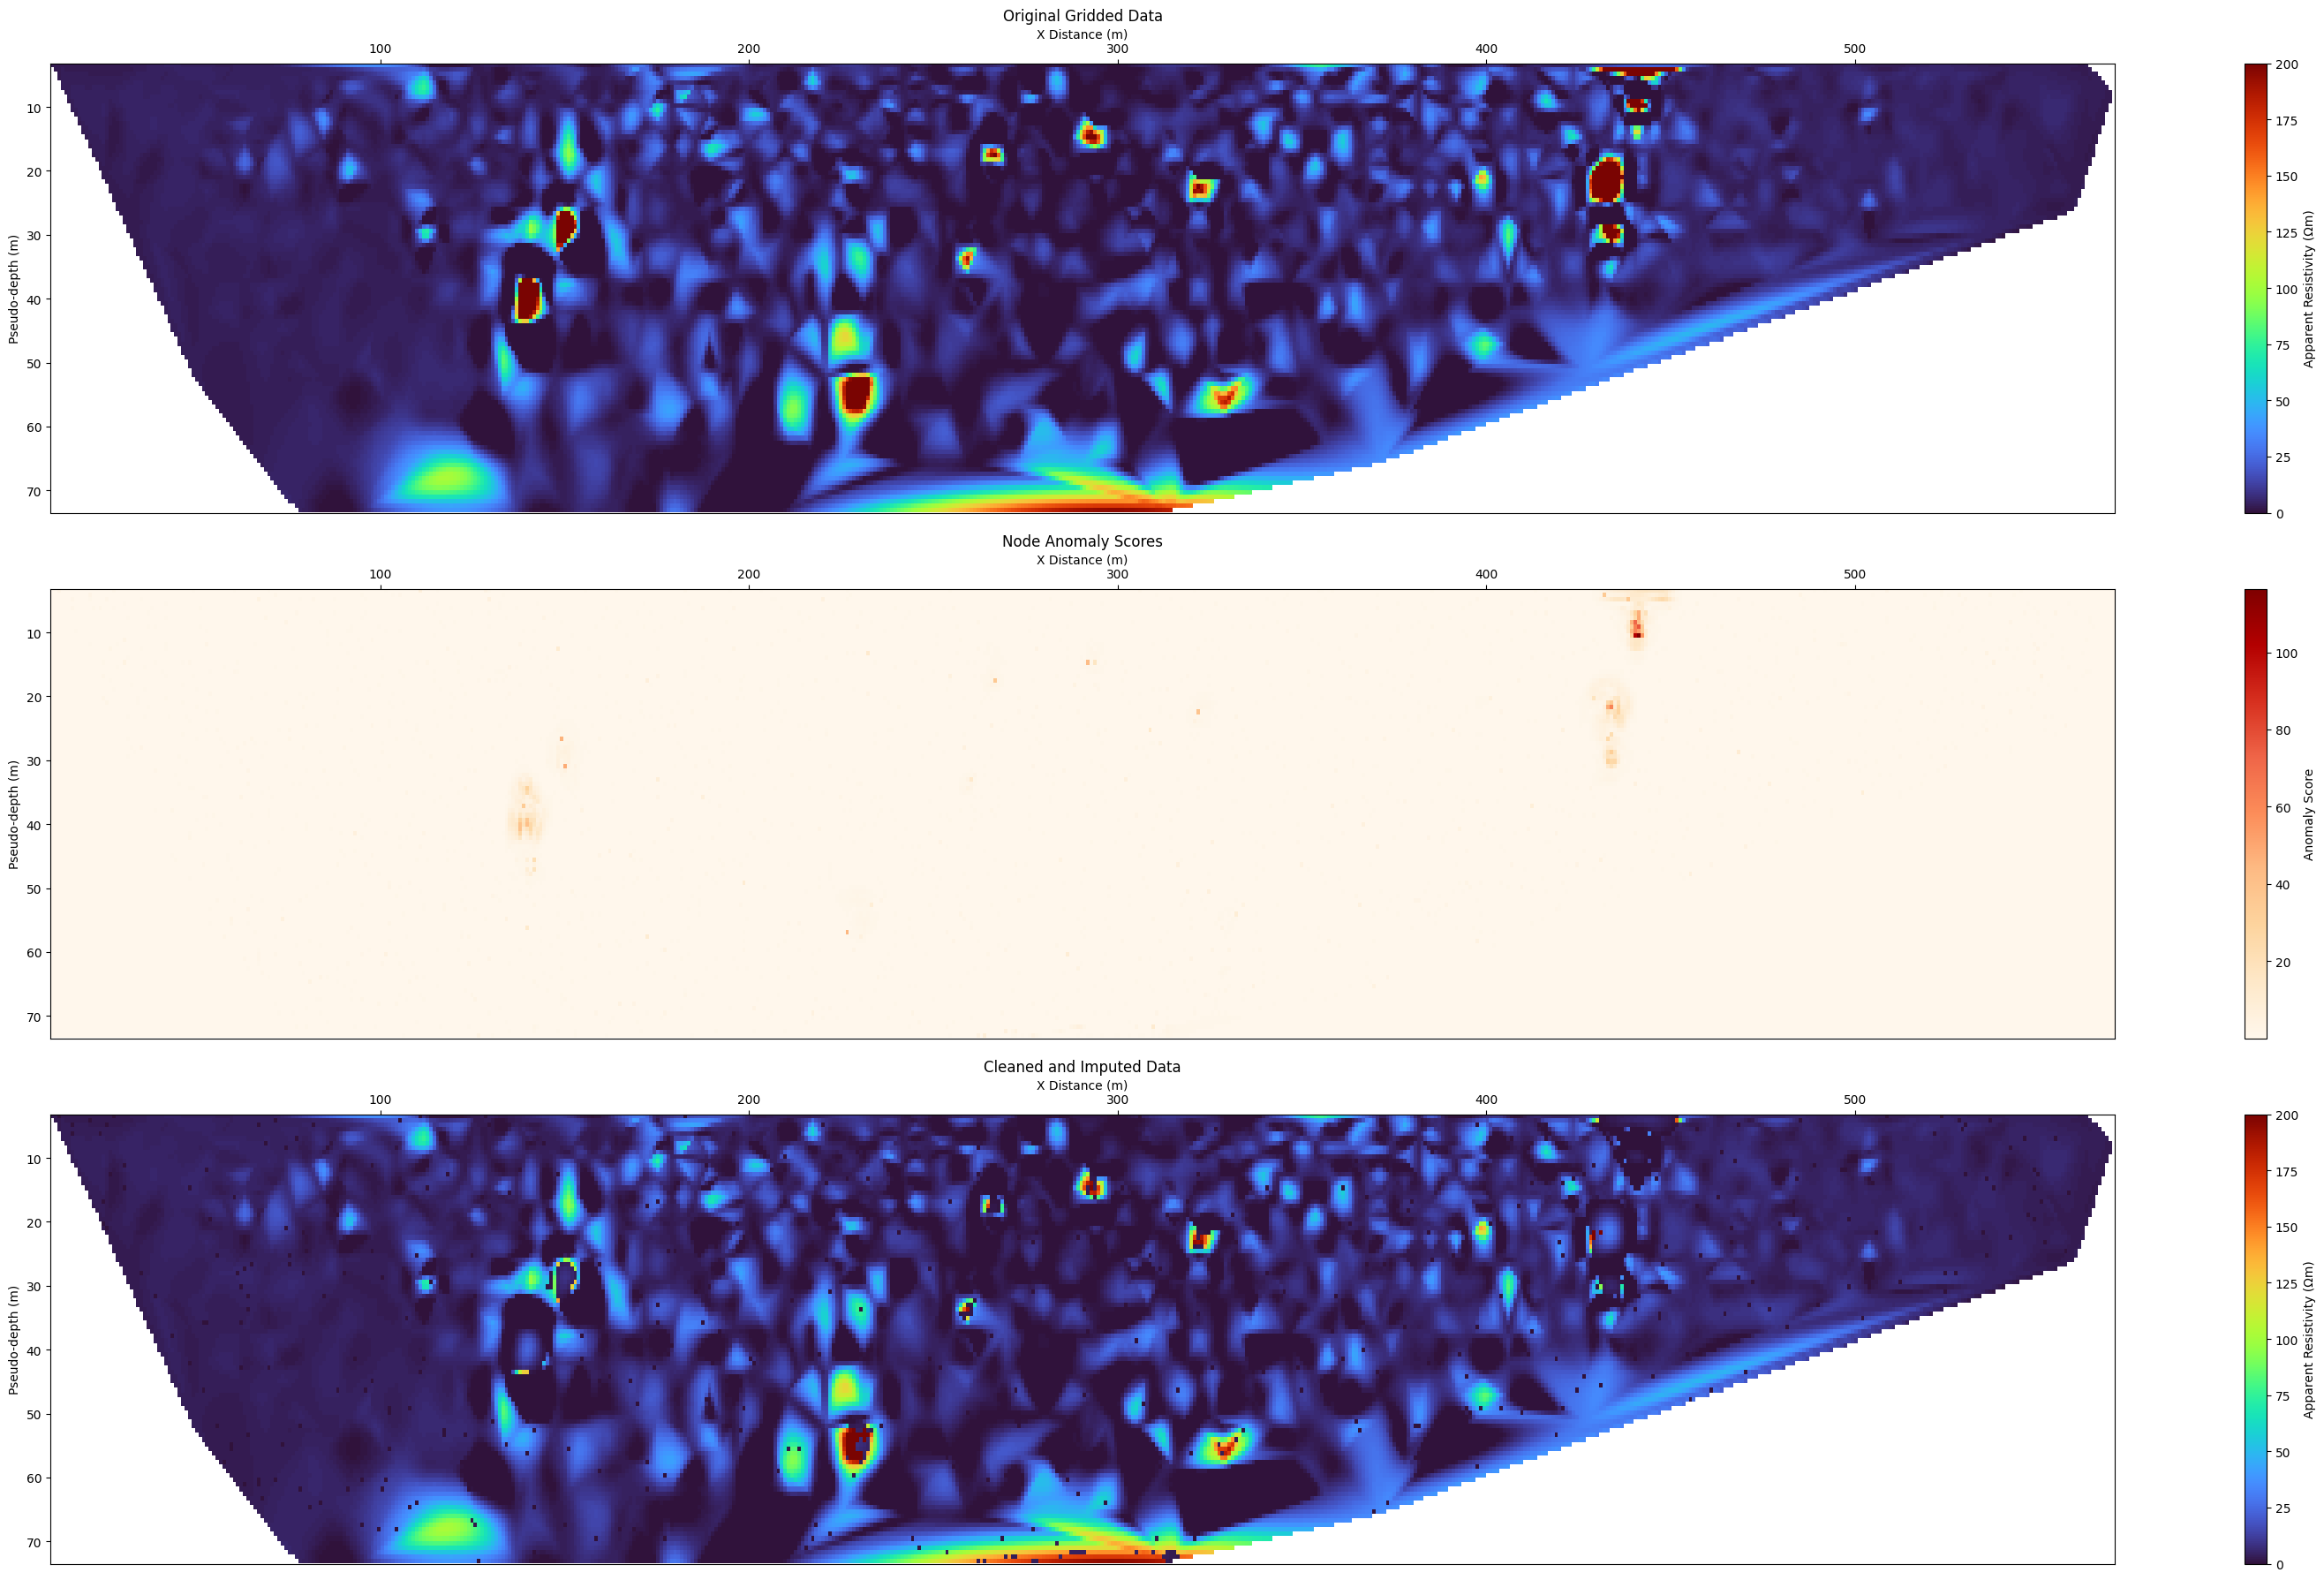

Visualization complete.


In [68]:
# Assuming gridded_resistivity, xi, zi, height, width are available from previous steps

# 1. Build the graph
if 'mean_feature' not in locals() or 'median_feature' not in locals() or 'std_feature' not in locals() or 'var_feature' not in locals():
    print("Calculating statistical features...")
    mean_feature, median_feature, std_feature, var_feature = calculate_statistical_features(gridded_resistivity)

# Call calculate_gradient_features if not already done
if 'gradient_x' not in locals() or 'gradient_z' not in locals() or 'gradient_magnitude' not in locals():
     print("Calculating gradient features...")
     gradient_x, gradient_z, gradient_magnitude = calculate_gradient_features(gridded_resistivity)

# Call calculate_lof_feature if not already done
if 'lof_feature' not in locals():
    print("Calculating LOF features...")
    lof_feature = calculate_lof_feature(gridded_resistivity)


# Assemble and standardize the features
standardized_feature_matrix = assemble_and_standardize_features(
    gridded_resistivity,
    lof_feature,
    mean_feature,
    median_feature,
    std_feature,
    var_feature,
    gradient_x,
    gradient_z,
    gradient_magnitude
)

graph_data = build_graph(standardized_feature_matrix, height, width)
print("Graph built successfully.")
print(graph_data)

# 2. Instantiate and train the GAE model
# Define dimensions
in_channels = standardized_feature_matrix.shape[1] # Number of features per node
latent_dim = 16 # Example latent dimension
intermediate_dim = 32 # Example intermediate dimension

model = GraphAutoencoder(in_channels, latent_dim, intermediate_dim)
print("GraphAutoencoder model instantiated.")

# Define training parameters
epochs = 200 # Example number of epochs
learning_rate = 0.001 # Example learning rate

print(f"Training GAE for {epochs} epochs with learning rate {learning_rate}...")
trained_model = train_gae(model, graph_data, epochs, learning_rate)
print("GAE training complete.")

# 3. Calculate anomaly scores
print("Calculating anomaly scores...")
anomaly_scores, anomaly_mask = calculate_anomaly_scores(trained_model, graph_data, percentile=98)
print("Anomaly scores calculated.")

# Reshape anomaly scores to 2D grid for visualization
anomaly_scores_2d = anomaly_scores.reshape(height, width)

# 4. Impute anomalies
print("Imputing anomalies...")
# Need the reconstructed features from the trained model for imputation
trained_model.eval()
with torch.no_grad():
    reconstructed_features = trained_model(graph_data.x, graph_data.edge_index).numpy()


cleaned_gridded_resistivity = impute_anomalies(gridded_resistivity, anomaly_mask, reconstructed_features, height, width)
print("Anomalies imputed.")

# 5. Visualize the results
print("Visualizing results...")
visualize_results(gridded_resistivity, anomaly_scores_2d, cleaned_gridded_resistivity, xi, zi)
print("Visualization complete.")

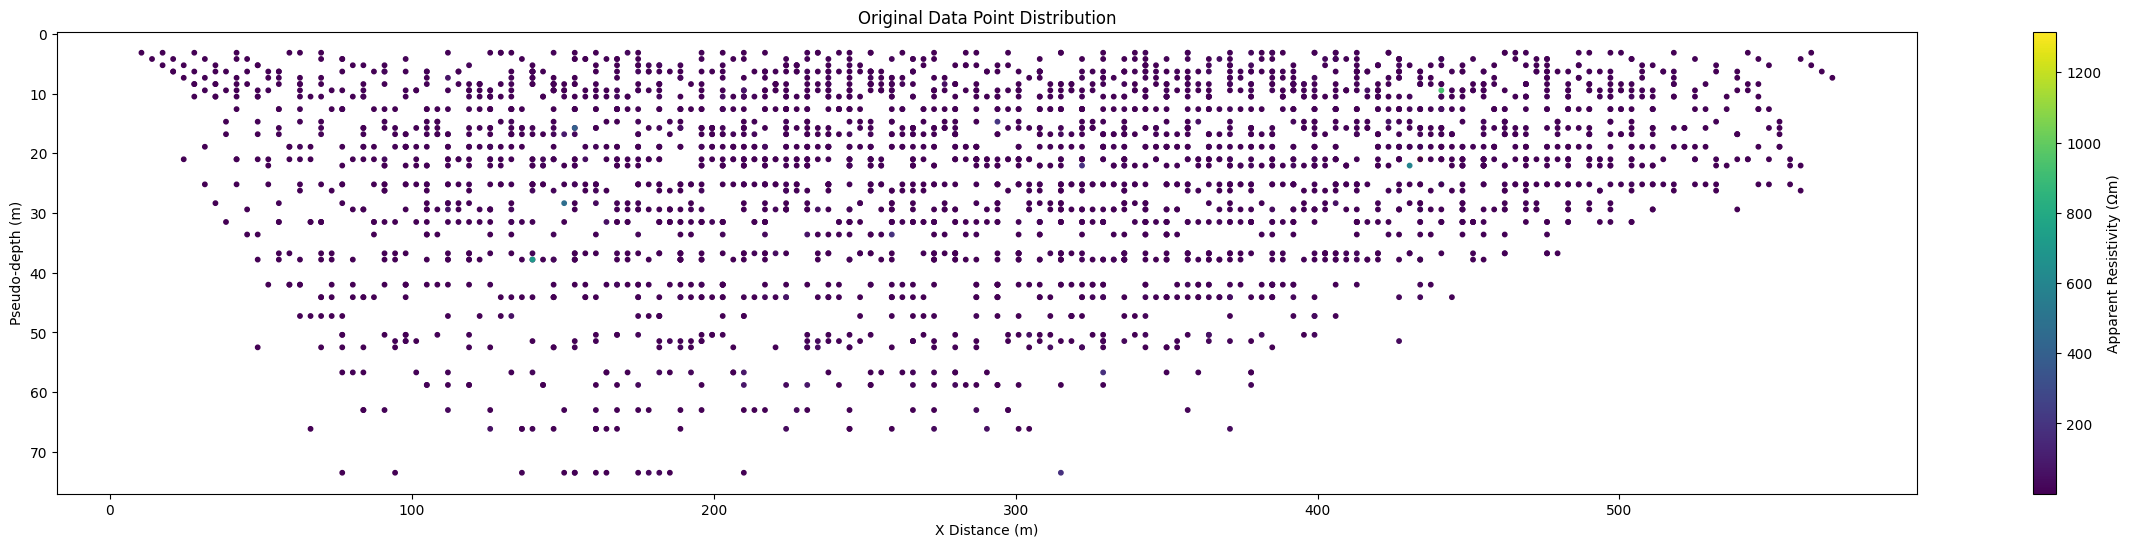

In [61]:
import matplotlib.pyplot as plt

# Create a scatter plot of the original data points
plt.figure(figsize=(30, 6))
plt.scatter(df['X_plot'], df['Z_plot'], c=df['A_resistivity'], cmap='viridis', s=10) # Using A_resistivity for color

# Invert the y-axis to represent depth increasing downwards
plt.gca().invert_yaxis()

# Add a colorbar
plt.colorbar(label='Apparent Resistivity (Ωm)')

# Set labels and title
plt.xlabel('X Distance (m)')
plt.ylabel('Pseudo-depth (m)')
plt.title('Original Data Point Distribution')

plt.show()

Visualizing results...


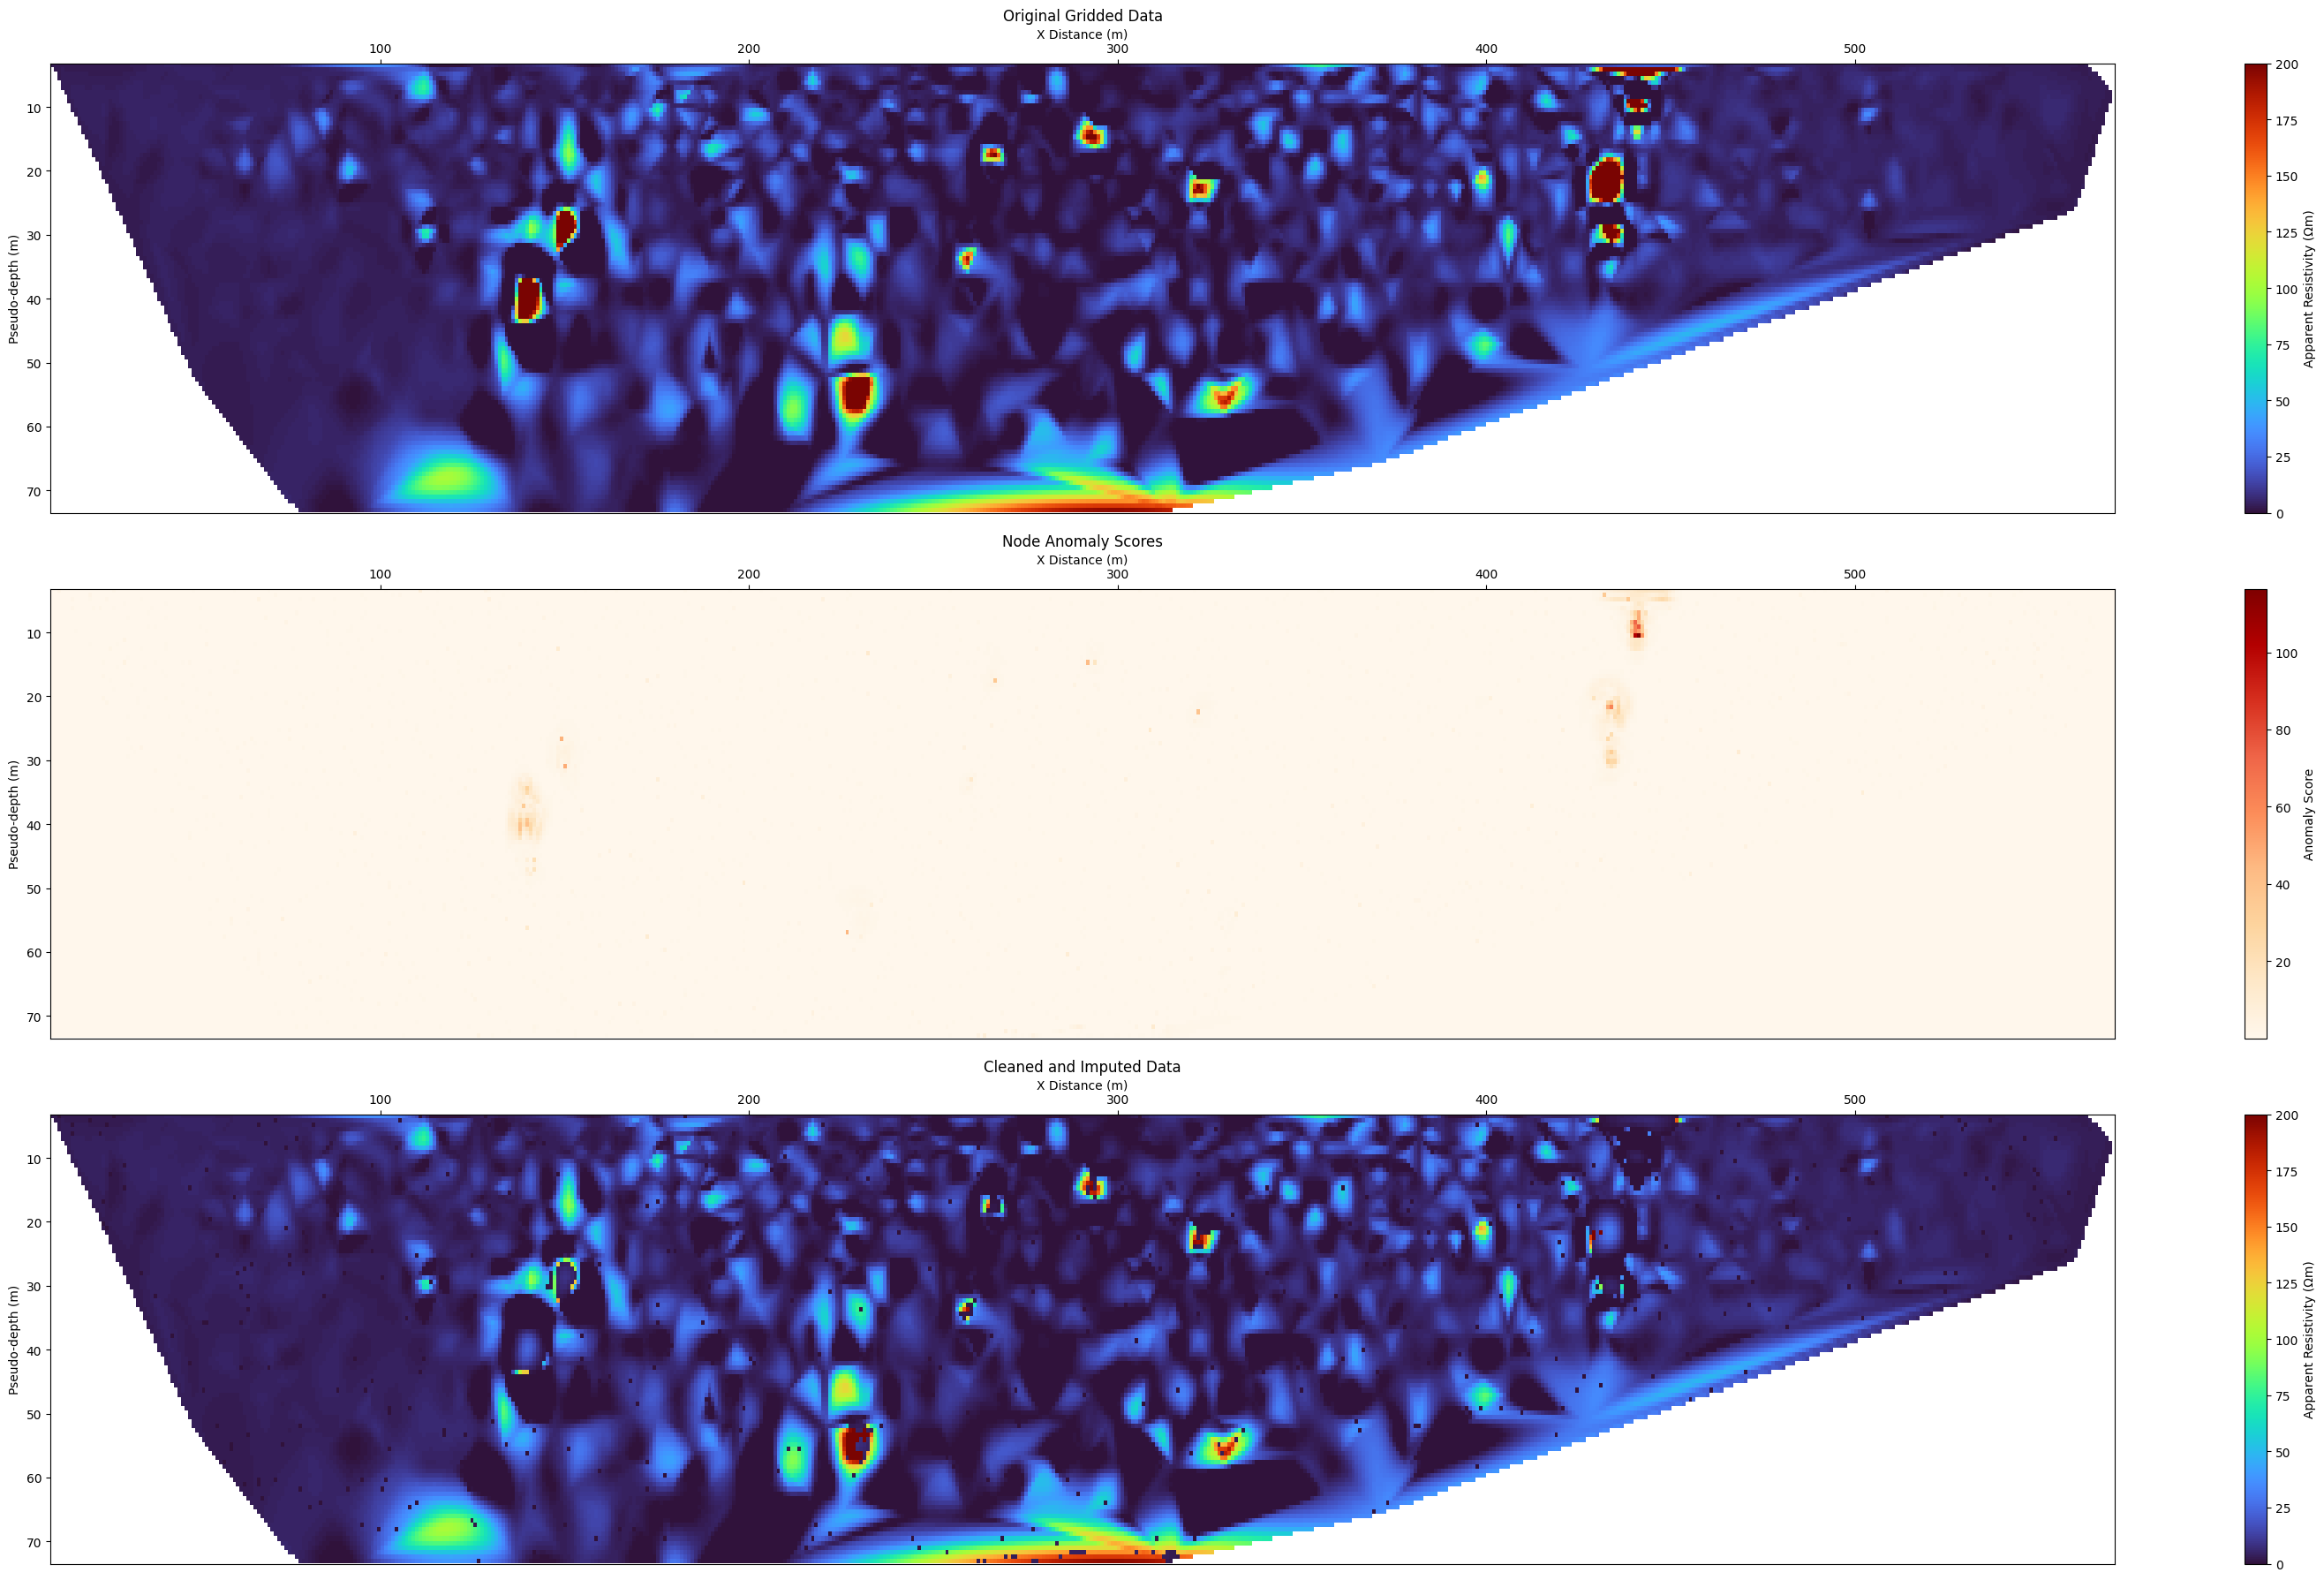

Visualization complete.


In [69]:
# 5. Visualize the results
print("Visualizing results...")
visualize_results(gridded_resistivity, anomaly_scores_2d, cleaned_gridded_resistivity, xi, zi)
print("Visualization complete.")

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


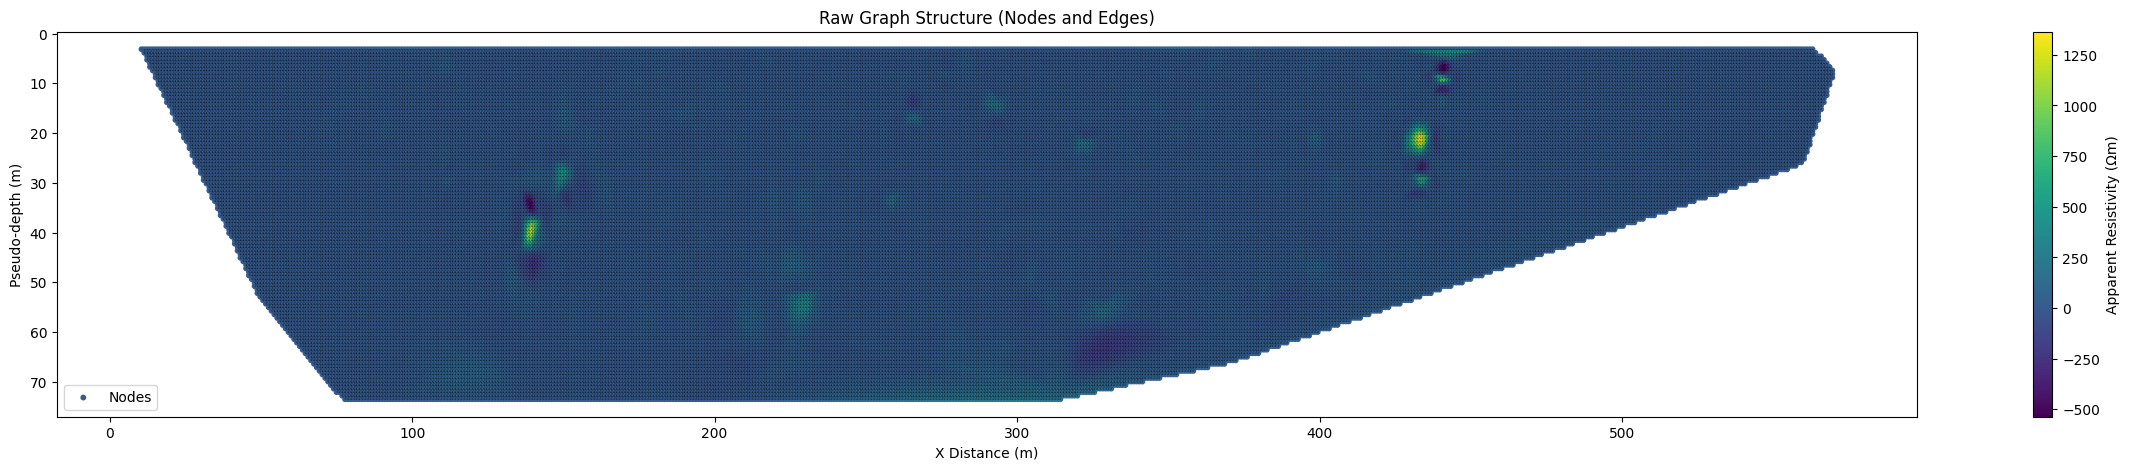

In [70]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Assuming xi, zi, and graph_data are available from previous steps

# Reshape xi and zi to get 1D arrays of node coordinates
x_coords = xi.flatten()
z_coords = zi.flatten()

# Get the node features (already standardized in graph_data.x)
node_features = graph_data.x.numpy()

# Get the edge index
edge_index = graph_data.edge_index.numpy()

# Create the plot
plt.figure(figsize=(30, 5))

# Plot nodes
node_colors = gridded_resistivity.flatten()

# Remove NaN values for plotting nodes
valid_indices = ~np.isnan(node_colors)
plt.scatter(x_coords[valid_indices], z_coords[valid_indices], c=node_colors[valid_indices], cmap='viridis', s=10, label='Nodes')

# Plot edges
for i in range(edge_index.shape[1]):
    start_node_index = edge_index[0, i]
    end_node_index = edge_index[1, i]

    # Check if the nodes are valid (not NaN in original gridded_resistivity for simplicity in plotting)
    if valid_indices[start_node_index] and valid_indices[end_node_index]:
        x_start, z_start = x_coords[start_node_index], z_coords[start_node_index]
        x_end, z_end = x_coords[end_node_index], z_coords[end_node_index]
        plt.plot([x_start, x_end], [z_start, z_end], 'k-', linewidth=0.5, alpha=0.1) # Black lines with low transparency

# Invert the y-axis to represent depth increasing downwards
plt.gca().invert_yaxis()

# Add a colorbar for node colors (resistivity)
plt.colorbar(label='Apparent Resistivity (Ωm)')

# Set labels and title
plt.xlabel('X Distance (m)')
plt.ylabel('Pseudo-depth (m)')
plt.title('Raw Graph Structure (Nodes and Edges)')

# Add a legend
plt.legend()

plt.show()